# Feature Engineering For Time Series Data

In [2]:
import pandas as pd                       
data = pd.read_csv('Train_SU63ISt.csv')
data.head()

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


Change the DateTime column format from object to a pandas' DateTime so it won't be treated as a categorical variable

In [3]:
data['Datetime'] = pd.to_datetime(data['Datetime'],format='%d-%m-%Y %H:%M') 

We can capture seasonality in the time series by creating, month year, day of the week, etc.

Having information about the day, month, year, etc. can be useful for forecasting the values.

In [4]:
data['year']=data['Datetime'].dt.year 
data['month']=data['Datetime'].dt.month 
data['day']=data['Datetime'].dt.day

data['dayofweek_num']=data['Datetime'].dt.dayofweek  
data['dayofweek_name']=data['Datetime'].dt.day_name()

data.head()

,ID,Datetime,Count,year,month,day,dayofweek_num,dayofweek_name
0,0,2012-08-25 00:00:00,8,2012,8,25,5,Saturday
1,1,2012-08-25 01:00:00,2,2012,8,25,5,Saturday
2,2,2012-08-25 02:00:00,6,2012,8,25,5,Saturday
3,3,2012-08-25 03:00:00,2,2012,8,25,5,Saturday
4,4,2012-08-25 04:00:00,2,2012,8,25,5,Saturday


We can similarly extract hourly seasonality trends by creating 'hour' and 'minute' features

In [5]:
data['Hour'] = data['Datetime'].dt.hour 
data['minute'] = data['Datetime'].dt.minute 
data.head()

,ID,Datetime,Count,year,month,day,dayofweek_num,dayofweek_name,Hour,minute
0,0,2012-08-25 00:00:00,8,2012,8,25,5,Saturday,0,0
1,1,2012-08-25 01:00:00,2,2012,8,25,5,Saturday,1,0
2,2,2012-08-25 02:00:00,6,2012,8,25,5,Saturday,2,0
3,3,2012-08-25 03:00:00,2,2012,8,25,5,Saturday,3,0
4,4,2012-08-25 04:00:00,2,2012,8,25,5,Saturday,4,0


Since this is a time series, we can (should) have lagged target values as features

In [10]:
data['lag_1'] = data['Count'].shift(1)
data['lag_2'] = data['Count'].shift(2)
data['lag_3'] = data['Count'].shift(3)
data['lag_4'] = data['Count'].shift(4)
data['lag_5'] = data['Count'].shift(5)
data['lag_6'] = data['Count'].shift(6)
data['lag_7'] = data['Count'].shift(7)

data_reduced = data[['Datetime', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'Count']]
data_reduced.head(10)

,Datetime,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,Count
0,2012-08-25 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
1,2012-08-25 01:00:00,8.0,NaN,NaN,NaN,NaN,NaN,NaN,2
2,2012-08-25 02:00:00,2.0,8.0,NaN,NaN,NaN,NaN,NaN,6
3,2012-08-25 03:00:00,6.0,2.0,8.0,NaN,NaN,NaN,NaN,2
4,2012-08-25 04:00:00,2.0,6.0,2.0,8.0,NaN,NaN,NaN,2
5,2012-08-25 05:00:00,2.0,2.0,6.0,2.0,8.0,NaN,NaN,2
6,2012-08-25 06:00:00,2.0,2.0,2.0,6.0,2.0,8.0,NaN,2
7,2012-08-25 07:00:00,2.0,2.0,2.0,2.0,6.0,2.0,8.0,2
8,2012-08-25 08:00:00,2.0,2.0,2.0,2.0,2.0,6.0,2.0,6
9,2012-08-25 09:00:00,6.0,2.0,2.0,2.0,2.0,2.0,6.0,2


To pick the right number of lags we should look at the PACF (partial ACF) plot

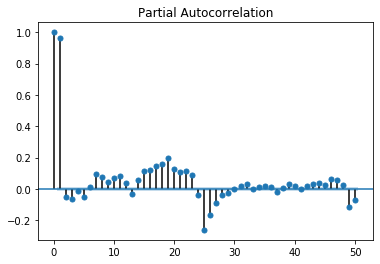

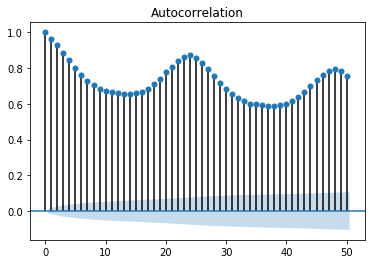

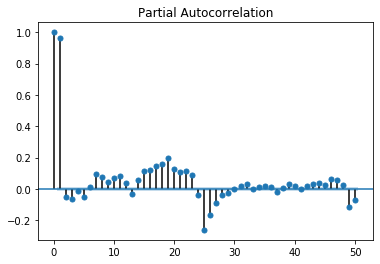

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data['Count'], lags=50) 
plot_pacf(data['Count'], lags=50)

Based on the domain knowledge you can come up with some feature that might be helpful, for example, mean of the last 5 lags:

In [18]:
data['rolling_mean'] = data['Count'].rolling(window=5).mean()
reduced = data[['Datetime', 'rolling_mean', 'Count']]
reduced.head(10)

,Datetime,rolling_mean,Count
0,2012-08-25 00:00:00,NaN,8
1,2012-08-25 01:00:00,NaN,2
2,2012-08-25 02:00:00,NaN,6
3,2012-08-25 03:00:00,NaN,2
4,2012-08-25 04:00:00,4.0,2
5,2012-08-25 05:00:00,2.8,2
6,2012-08-25 06:00:00,2.8,2
7,2012-08-25 07:00:00,2.0,2
8,2012-08-25 08:00:00,2.8,6
9,2012-08-25 09:00:00,2.8,2


For the traditional machine learning problems, we randomly select subsets of data for the validation and test sets. But in time series, each data point is dependent on its past values. Randomly shufflling the data does not work in this case. We should split the training and validation sets by tome sstamps, for example the last 20 percent of data in time domain (last 3 months) goes into valication set.

In [19]:
data['Datetime'].min(), data['Datetime'].max(), (data['Datetime'].max() -data['Datetime'].min())

(Timestamp('2012-08-25 00:00:00'),
 Timestamp('2014-09-25 23:00:00'),
 Timedelta('761 days 23:00:00'))

In [20]:
data.index = data.Datetime 
training_set = data.loc['2012-08-25':'2014-06-24'] 
validation_set = data.loc['2014-06-25':'2014-09-25'] 
training_set.shape, validation_set.shape

((16056, 18), (2232, 18))